In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve
import time, re, os, sys

In [2]:
VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


## Processing data files

#### Load ARK files 
ARK files are loaded dataframes of x utterances each, and each of these are stored into a single HDF5 store per file. Each utterance has a corresponding 400-dim vector that is the 'vertical' average of utterance data.

In [13]:
def ark_to_hdf5(filename, test = False, num_utts = 100 ):
    HDFS_Name = filename+".h5"
    try:
        os.remove(HDFS_Name)
    except OSError:
        pass
    
    store = pd.HDFStore(HDFS_Name)
    df = pd.DataFrame(columns = [[str(x) for x in range(VEC_DIM)]])
    df_count = 0
    
    with open(FILE_DIR+filename, 'r') as f:
        working_data = []
        utt_id_past = ""
        
        for line in f:
            
            if(line[:2].isalpha()):
                utt_id = line[:line.index("[")-2]
                if not utt_id_past:
                    utt_id_past = utt_id
                if working_data:
                    
                    # WRITE THE AVERAGE UTTERANCE VECTOR FOR EACH UTTERANCE
                    df.loc[utt_id_past] = normalize([np.mean(np.array(working_data, dtype="float64"), axis=0)], axis=1)[0]
                    # Reset temp vars
                    if len(df)>=num_utts:
                        # WRITE TO HDF5 STORE
                        name = filename[:-4]+str(df_count)
                        df.to_hdf(HDFS_Name,name ,format="table")
                        df = df.iloc[0:0] # Reset df
                        
                        df_count+=1
                        print("Dataframes produced: ", df_count, "(",name,")")  
                        
                        
                    working_data = []
                    utt_id_past = utt_id
            else:
                # Add line as another row to the working matrix of df_utterance
                if "]" in line[-3:]: line = line[:-2]
                working_data.append(line.strip().split())
                
        if working_data:
            df.loc[utt_id_past] = normalize([np.mean(np.array(working_data, dtype="float64"), axis=0)], axis=1)[0]
            name = filename[:-4]+str(df_count)
            df.to_hdf(HDFS_Name,name ,format="table")
            print("Dataframes produced: ", df_count+1, "(",name,")")  
            
            
    return store

In [14]:
enroll_store = ark_to_hdf5("enroll.ark")

Dataframes produced:  1 ( enroll0 )
Dataframes produced:  2 ( enroll1 )
Dataframes produced:  3 ( enroll2 )
Dataframes produced:  4 ( enroll3 )
Dataframes produced:  5 ( enroll4 )
Dataframes produced:  6 ( enroll5 )
Dataframes produced:  7 ( enroll6 )
Dataframes produced:  8 ( enroll7 )
Dataframes produced:  9 ( enroll8 )
Dataframes produced:  10 ( enroll9 )
Dataframes produced:  11 ( enroll10 )
Dataframes produced:  12 ( enroll11 )
Dataframes produced:  13 ( enroll12 )
Dataframes produced:  14 ( enroll13 )
Dataframes produced:  15 ( enroll14 )
Dataframes produced:  16 ( enroll15 )
Dataframes produced:  17 ( enroll16 )
Dataframes produced:  18 ( enroll17 )
Dataframes produced:  19 ( enroll18 )
Dataframes produced:  20 ( enroll19 )
Dataframes produced:  21 ( enroll20 )
Dataframes produced:  22 ( enroll21 )
Dataframes produced:  23 ( enroll22 )
Dataframes produced:  24 ( enroll23 )
Dataframes produced:  25 ( enroll24 )
Dataframes produced:  26 ( enroll25 )
Dataframes produced:  27 ( enro

In [15]:
test_store = ark_to_hdf5("test.ark", True, 1000)

Dataframes produced:  1 ( test0 )
Dataframes produced:  2 ( test1 )
Dataframes produced:  3 ( test2 )
Dataframes produced:  4 ( test3 )
Dataframes produced:  5 ( test4 )
Dataframes produced:  6 ( test5 )
Dataframes produced:  7 ( test6 )
Dataframes produced:  8 ( test7 )
Dataframes produced:  9 ( test8 )
Dataframes produced:  10 ( test9 )
Dataframes produced:  11 ( test10 )
Dataframes produced:  12 ( test11 )
Dataframes produced:  13 ( test12 )
Dataframes produced:  14 ( test13 )
Dataframes produced:  15 ( test14 )
Dataframes produced:  16 ( test15 )
Dataframes produced:  17 ( test16 )
Dataframes produced:  18 ( test17 )
Dataframes produced:  19 ( test18 )
Dataframes produced:  20 ( test19 )
Dataframes produced:  21 ( test20 )
Dataframes produced:  22 ( test21 )
Dataframes produced:  23 ( test22 )
Dataframes produced:  24 ( test23 )
Dataframes produced:  25 ( test24 )
Dataframes produced:  26 ( test25 )
Dataframes produced:  27 ( test26 )
Dataframes produced:  28 ( test27 )
Dataframes 

In [9]:
enroll_ark = dd.read_hdf("enroll.ark.h5", key='/*')
test_ark = dd.read_hdf("test.ark.h5", key = '/*')

#### Load spk2utt files
The spk2utt files can either be loaded or directly processed so that we can obtain a single result vector for each speaker.

In [10]:
def read_spk2utt(filename, ark_df):
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    
    def get_vectors(x):
        
        def avg_func(x):
             return (delayed(np.mean)([delayed(ark_df).loc[y].values for y in x.values[1:]], axis=0))
        
        # choose function to process vecs in 
        res = avg_func(x) 
        return res
    
    res = df.apply(get_vectors, axis=1)
    
    with ProgressBar():
        res = dd.compute(*res)
    
    # normalize result
    res = normalize(np.array(res),axis=1)
    
    res_df = pd.DataFrame(res,columns=[str(x) for x in range(VEC_DIM)])
    res_df.index = df['id']
    return res_df

def read_spk2utt_raw(filename, ark_df):
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    
    def get_vectors(x):
        
        return [delayed(ark_df).loc[y].values for y in x.values[1:]]
        
    res = df.apply(get_vectors, axis=1)
    
    # show progress and compute result from dask to memory
    pbar = ProgressBar()
    pbar.register()
    res = dd.compute(*res)
    pbar.unregister()
    
    res = np.array(res).reshape((-1,400))
    
    index = pd.MultiIndex.from_product([df['id'], df.columns[1:]], names = ['id', 'utt'])
    
    res_df = pd.DataFrame(res, index = index,columns=[str(x) for x in range(VEC_DIM)])

    return res_df

In [11]:
spk_raw = pd.HDFStore("spk_raw.h5")

In [12]:
enroll_spk_raw = read_spk2utt_raw("enroll.spk2utt", enroll_ark)
enroll_spk_raw.to_hdf('spk_raw.h5', "enroll_raw" ,format="table")
enroll_spk_raw.head()

[########################################] | 100% Completed |  3.9s


0         1         2         3         4         5  \
id         utt                                                                
4780420411 utt1  0.016057  0.063447  0.024169  0.020488  0.067268  0.111295   
           utt2  0.004132  0.042350  0.026292  0.021213  0.055774  0.099405   
           utt3  0.003735  0.060417  0.041474  0.007404  0.067067  0.119366   
           utt4  0.023073  0.047888  0.017589  0.011351  0.062918  0.116655   
           utt5  0.021832  0.054759  0.016714  0.022291  0.057607  0.116154   

                        6         7         8         9    ...          390  \
id         utt                                             ...                
4780420411 utt1  0.075458  0.002725  0.047470  0.044406    ...     0.082196   
           utt2  0.056854  0.000000  0.059910  0.034133    ...     0.089012   
           utt3  0.052364  0.000000  0.056909  0.056164    ...     0.094812   
           utt4  0.081408  0.000000  0.031385  0.042443    ...     0.061069   
           utt5  0.078686  0.000058  0.028728  0.043503    ...     0.055377   

                      391       392       393       394       395       396  \
id         utt                                                                
4780420411 utt1  0.031757  0.026153  0.028168  0.026362  0.048117  0.040820   
           utt2  0.023073  0.018801  0.033256  0.028867  0.053247  0.054419   
           utt3  0.061538  0.017183  0.027635  0.032651  0.042445  0.030427   
           utt4  0.027534  0.018113  0.026473  0.038839  0.047355  0.027251   
           utt5  0.017151  0.030925  0.022040  0.046488  0.039413  0.024504   

                      397       398       399  
id         utt                                 
4780420411 utt1  0.025251  0.012643  0.081232  
           utt2  0.009181  0.002636  0.048796  
           utt3  0.012174  0.007087  0.087498  
           utt4  0.014266  0.017972  0.052178  
           utt5  0.018720  0.016129  0.077600  

[5 rows x 400 columns]

In [13]:
test_spk_raw = read_spk2utt_raw("test.spk2utt", test_ark)
test_spk_raw.to_hdf('spk_raw.h5', "test_raw" ,format="table")
test_spk_raw.head()

[########################################] | 100% Completed |  1min  4.6s


0         1         2         3         4  \
id              utt                                                      
fc_4779547143_0 utt1  0.020170  0.059518  0.056153  0.032068  0.065329   
                utt2  0.011560  0.047106  0.051897  0.044764  0.059249   
                utt3  0.020007  0.043752  0.036605  0.037457  0.063036   
fc_4779547143_1 utt1  0.009364  0.049788  0.039429  0.025972  0.051585   
                utt2  0.013280  0.060053  0.052686  0.038949  0.062854   

                             5         6         7         8         9  \
id              utt                                                      
fc_4779547143_0 utt1  0.087469  0.057539  0.000201  0.042275  0.047615   
                utt2  0.092769  0.076523  0.000284  0.046906  0.058526   
                utt3  0.106334  0.072663  0.003421  0.056123  0.044230   
fc_4779547143_1 utt1  0.101029  0.070800  0.002879  0.061402  0.043894   
                utt2  0.096134  0.072066  0.001623  0.053310  0.045103   

                        ...          390       391       392       393  \
id              utt     ...                                              
fc_4779547143_0 utt1    ...     0.079530  0.036337  0.011925  0.002385   
                utt2    ...     0.094327  0.042447  0.009960  0.000182   
                utt3    ...     0.077634  0.056419  0.020000  0.000816   
fc_4779547143_1 utt1    ...     0.068326  0.046697  0.027888  0.000011   
                utt2    ...     0.092691  0.029286  0.012007  0.000699   

                           394       395       396       397       398  \
id              utt                                                      
fc_4779547143_0 utt1  0.058947  0.047423  0.030371  0.020992  0.029398   
                utt2  0.047811  0.053093  0.030242  0.027020  0.043752   
                utt3  0.045481  0.049301  0.030399  0.044701  0.033541   
fc_4779547143_1 utt1  0.044846  0.061659  0.017455  0.038569  0.026123   
                utt2  0.056133  0.051194  0.018357  0.037050  0.041966   

                           399  
id              utt             
fc_4779547143_0 utt1  0.088758  
                utt2  0.088348  
                utt3  0.100673  
fc_4779547143_1 utt1  0.093698  
                utt2  0.080086  

[5 rows x 400 columns]

In [14]:
enroll_spk = read_spk2utt("enroll.spk2utt", enroll_ark)
enroll_spk.to_hdf('spk.h5', "enroll" ,format="table")
enroll_spk.head()

[########################################] | 100% Completed |  3.7s


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


In [15]:
test_spk = read_spk2utt("test.spk2utt", test_ark)
test_spk.to_hdf('spk.h5', "test" ,format="table")
test_spk.head()

[########################################] | 100% Completed |  1min 10.3s


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
fc_4779547143_0,0.017340,0.050399,0.048482,0.038304,0.062879,0.096046,0.069285,0.001309,0.048699,0.050397,...,0.084288,0.045314,0.014038,0.001134,0.051024,0.050212,0.030503,0.031073,0.035758,0.093099
fc_4779547143_1,0.012684,0.050277,0.049501,0.036990,0.060518,0.102713,0.075189,0.002106,0.058346,0.043179,...,0.081335,0.037787,0.019940,0.000346,0.052601,0.049489,0.018926,0.038731,0.038115,0.088461
fc_4779547143_2,0.019770,0.061267,0.045702,0.027630,0.067810,0.091911,0.071410,0.002919,0.033406,0.062641,...,0.085100,0.035510,0.015567,0.004496,0.054108,0.038457,0.016548,0.032887,0.049424,0.088594
fc_4779547143_3,0.024492,0.050100,0.057484,0.032810,0.064936,0.092417,0.068532,0.000242,0.043173,0.053019,...,0.083242,0.042559,0.019817,0.001212,0.054874,0.045079,0.029587,0.029431,0.039689,0.084741
fc_4779547143_4,0.017647,0.066743,0.042606,0.035684,0.054024,0.093948,0.076272,0.005478,0.042781,0.051019,...,0.084277,0.033605,0.020398,0.001326,0.056036,0.059644,0.023362,0.026157,0.028900,0.078883


In [3]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

enroll_spk.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


#### Load Trials
We can load trial data into a simple dataframe.

In [4]:
def read_trials(filename):
    df = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    return df

In [5]:
pairs = read_trials("trials")
print("num of trials: ",len(pairs))

# Encode "nontarget" as 0, "target as 1"
pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
pairs.head()

num of trials:  11725308


,enroll,test_id,result
0,4780420411,fc_4779547143_0,0
1,4780420411,fc_4779547143_1,0
2,4780420411,fc_4779547143_2,0
3,4780420411,fc_4779547143_3,0
4,4780420411,fc_4779547143_4,0


In [19]:
pairs['result'].value_counts()

0    11707416
1       17892
Name: result, dtype: int64

# Scoring methods

In [7]:
def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

ESPK = enroll_spk
TSPK = test_spk
score_func = cos_similarity
def score_vectors(x):
    """
    enroll_id: ID of enrolled speaker 
    test_id: ID of a test speaker
    enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
    test_spk: As enroll_spk
    score_func: scoring function that takes 2 speakers' data and produces a score
    """
    enroll_data = ESPK.loc[x['enroll']] # Pandas series
    test_data = TSPK.loc[x['test_id']]
    res = score_func(enroll_data, test_data)
    return res

In [9]:
dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= 0.1, random_state=1)
#dask_pairs = dd.from_pandas(pairs, npartitions=16)
meta = ('x','f8')

scores = 0

pbar = ProgressBar()
pbar.register()
scores = dask_pairs.map_partitions(lambda df: df.apply(lambda x: score_vectors(x),axis=1), meta=meta).compute()
pbar.unregister()

[##############################          ] | 75% Completed |  3min 22.5s


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/work4/kenneth/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-c699d6f0639b>", line 9, in <module>
    scores = dask_pairs.map_partitions(lambda df: df.apply(lambda x: score_vectors(x),axis=1), meta=meta).compute()
  File "/work4/kenneth/anaconda3/lib/python3.6/site-packages/dask/base.py", line 154, in compute
    (result,) = compute(self, traverse=False, **kwargs)
  File "/work4/kenneth/anaconda3/lib/python3.6/site-packages/dask/base.py", line 407, in compute
    results = get(dsk, keys, **kwargs)
  File "/work4/kenneth/anaconda3/lib/python3.6/site-packages/dask/threaded.py", line 75, in get
    pack_exception=pack_exception, **kwargs)
  File "/work4/kenneth/anaconda3/lib/python3.6/site-packages/dask/local.py", line 512, in get_async
    key, res_info, failed = queue_get(queue)
  File "/work4/kenneth/anaconda3/lib/pyt

KeyboardInterrupt: 

## Calculating EER 

In [6]:
def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    fnr = 1 - tpr
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    
    if name:
        plt.savefig(name)
    
    return EER

In [16]:
res = 0
res = dask_pairs['result'].values.compute()

[########################################] | 100% Completed |  0.1s


0.07897028686774263

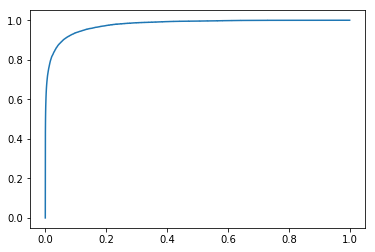

In [17]:
calcEER(scores, res)

## Test results

1. Average utterances - cosine similarity
    
    a. 0.01 Sample size - **0.07219**621377802078 EER
    
    b. 0.10 Sample size - **0.08433**577484037669 EER
    
    c. 0.50 Sample size - **0.08002**306213965407 EER
    
    d. 1.00 Sample size - **0.07947**910965152344 EER
    
    e. 1.00 Sample size - **0.078970**28686774263 EER - Revised - Utterances were not normalized before being averaged and normalized for each speaker 
    
    f. Data from (e) run through logistic regression - predicted probabilities and log preds produced exact same results
    

2. Mahalanobis dist 

    a. 0.01 Sample size - **0.517**2652405686168 EER - 
        
       Basic method: for each enrollment utterance distribution- get the MD with an averaged test vector, and softmax all results

3. KL divergence -revisted in Similarity Test KL.ipynb


# Archived

In [61]:
def read_ark(filename, num_partitions = 100):
    f = open(FILE_DIR+filename, 'r')
    p = Timer()
    df = dd.from_pandas(pd.DataFrame(columns = ['data']),npartitions=num_partitions) #DF of all utterances, indexed by UTT-ID
    working_data = ""
    df_temp = pd.DataFrame(columns = ['data'])
    utt_id_past = ""
    for line in f:
        if(line[:2]=="nn"): # line is beginning of an utterance
            
            utt_id = line[:line.index("[")-2]
            if not utt_id_past:
                utt_id_past = utt_id
            if working_data:
                df_temp.loc[utt_id_past] = [np.array(working_data.split(), dtype="float64").reshape((-1,400))]
                df = df.append(df_temp)
                # Reset temp vars
                df_temp = pd.DataFrame(columns = ['data'])
                working_data = ""
                utt_id_past = utt_id
                
            
        else:
            # Add line as another row to the working matrix of df_utterance
            if "]" in line[-3:]: line = line[:-2]
            working_data += " "+line.strip()
    
    p.out()
    return df

KeyboardInterrupt: 

In [3]:
def read_ark(filename):
    f = open(FILE_DIR+filename, 'r')
    file = re.split(r"nn",f.read())
    f.close()
    utterances = {} 
    for i in file[1:]:
        start_loc = i.index("[")
        
        data = i[start_loc+1:-3].split()
        if len(data)%400 != 0:
            print("utterance data is not of standard shape (length 400 vectors)")
            exit()
        utterance_data = sparse.csr_matrix(np.reshape(data,(-1,400)).astype('float64'))
        utterances["nn"+i[:start_loc-2]] = utterance_data
        
#         ids.append("nn"+i[:68])
#         vals.append(utterance_data)
#     df = pd.DataFrame(index=ids, data = vals, columns = ['data'])
#     return df.head()
    return utterances

In [ ]:
test_utt = read_ark("test.ark")

In [18]:
enroll_utt = read_ark("enroll.ark")
test_utt = read_ark("test.ark")

print("Number of enrolled utterances: ", len(enroll_utt.keys()))
print("Number of test utterances: ", len(test_utt.keys()))

In [ ]:
def read_spk2utt(filename, utt_data, func):
    """Processes the utterance vectors for each speaker
        func: function to apply to a list of utterance-ids per speaker
        filename: name of spk2utt file
        utt_data: dataframe of ark data"""
    process_count = 0
    df = pd.DataFrame(columns = [[str(x) for x in range(VEC_DIM)]])
    with open(FILE_DIR+filename, 'r') as f:
        for line in f:
            data = line.split()
            ID = data[0]
            UTT = data[1:]
            df.loc[ID] = func(UTT, utt_data)
            process_count+=1
            if process_count%50==0:
                print("Lines processed: ",process_count)
            
    return df

def average_UTT(utt_list, utt_data):
    df_filter = pd.DataFrame(index=utt_list)
    df_filter = dd.merge(df_filter, utt_data, left_index=True, right_index=True)
    total = df_filter.mean(axis=0)
    ret = normalize([total.values.compute()],axis=1)
    return ret[0]

In [25]:
dask_pairs = dd.from_pandas(pairs, 100000)
dask_pairs.head()

In [109]:
len(dask_pairs)

11725308

In [110]:
dask_pairs['enroll'] = dask_pairs['enroll'].apply(str)
dask_pairs['test_id'] = dask_pairs['test_id'].apply(str)

/work4/kenneth/anaconda3/lib/python3.6/site-packages/dask/dataframe/core.py:2165: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [111]:
dask_pairs = dd.merge(dask_pairs, enroll_spk, left_on='enroll', right_index=True)
dask_pairs = dd.merge(dask_pairs, test_spk, left_on = 'test_id', right_index = True)
dask_pairs.head()

,enroll,test_id,result,"('0',)_x","('1',)_x","('2',)_x","('3',)_x","('4',)_x","('5',)_x","('6',)_x",...,"(390_y,)","(391_y,)","(392_y,)","(393_y,)","(394_y,)","(395_y,)","(396_y,)","(397_y,)","(398_y,)","(399_y,)"
0,4780420411,fc_4779547143_0,0,0.44582,0.516698,0.395981,0.512293,0.476666,0.435907,0.478002,...,0.545298,0.458314,0.472239,0.944271,0.666225,0.547628,0.578137,0.373857,0.470131,0.552806
1,4780420411,fc_4779547143_1,0,0.44582,0.516698,0.395981,0.512293,0.476666,0.435907,0.478002,...,0.489346,0.710128,0.776473,0.014354,0.497808,0.710868,0.539585,0.583441,0.393006,0.619189
2,4780420411,fc_4779547143_2,0,0.44582,0.516698,0.395981,0.512293,0.476666,0.435907,0.478002,...,0.637944,0.647761,0.488007,0.034778,0.506738,0.503299,0.798863,0.629644,0.405951,0.504535
3,4780420411,fc_4779547143_3,0,0.44582,0.516698,0.395981,0.512293,0.476666,0.435907,0.478002,...,0.516855,0.798078,0.791792,0.210715,0.473028,0.348578,0.717828,0.601227,0.610640,0.660154
4,4780420411,fc_4779547143_4,0,0.44582,0.516698,0.395981,0.512293,0.476666,0.435907,0.478002,...,0.561021,0.587871,0.709411,0.030690,0.527914,0.634256,0.538189,0.609317,0.488367,0.599327


### Doing this manually without dask? - takes a lot longer

In [41]:
output[0]
4780420411
fc_4779547143_0 

Delayed('_inner-cf4c72bc19801a4da713143b466b3b8a')

In [56]:
cos_similarity(enroll_spk.loc["4780420411"], test_spk.loc["fc_4779547143_0"])
type(delayed(test_spk.loc["fc_4779547143_0"]).compute())
delayed(test_spk.loc)(["fc_4779547143_0"])

Delayed('<pandas.core.indexing._LocIndexer object at 0x7f3f05ce8458>-e58969d3-2001-4f12-a25d-8173d1a223d0')

In [ ]:
enroll_ids = pairs['enroll'].values 
test_ids = pairs['test_id'].values
output = []
for i in range(len(enroll_ids)):
    if i%100000==0:print(i)
    enroll_data = enroll_spk.loc[str(enroll_ids[i])]
    test_data = test_spk.loc[str(test_ids[i])]
    res = delayed(cos_similarity(enroll_data, test_data))
    output.append(res)
    
dask.compute(output)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000


In [132]:
class Timer():
    tick = int(time.time())
    def __init__(self, period=None):
        self.period = period
    def inc(self):
        if((time.time()-self.tick))%self.period<1:
            print("A period has passed: ",self.count)
            self.count+=1
    def out(self):
        return (int(time.time())-self.tick)

In [19]:
from sklearn import linear_model

In [ ]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(np.array(scores).reshape((-1,1)), res)

In [23]:
pred = log_reg.predict_proba(np.array(scores).reshape((-1,1)))
pred_log = log_reg.predict_log_proba(np.array(scores).reshape((-1,1)))
pred = pred[:,1:]
pred_log = pred_log[:,1:]